# <center>  Exploratory Data Analysis  </center>

In [202]:
from PIL import Image
import numpy as np
import os
import sys
sys.path
sys.path.append('/path/to/the/example_file.py')
import random
import matplotlib.pyplot as plt
import cv2
import shutil
from tqdm.notebook import tqdm
from collections import Counter
import seaborn as sns
sns.set_palette(sns.color_palette("husl", 9))

In [203]:
classes_names = ['Right_Scissors', 'Left_Scissors', 'Right_Needle_driver', 'Left_Needle_driver',
                 'Right_Forceps', 'Left_Forceps', 'Right_Empty', 'Left_Empty']

## Data Exploration

(480, 640, 3)


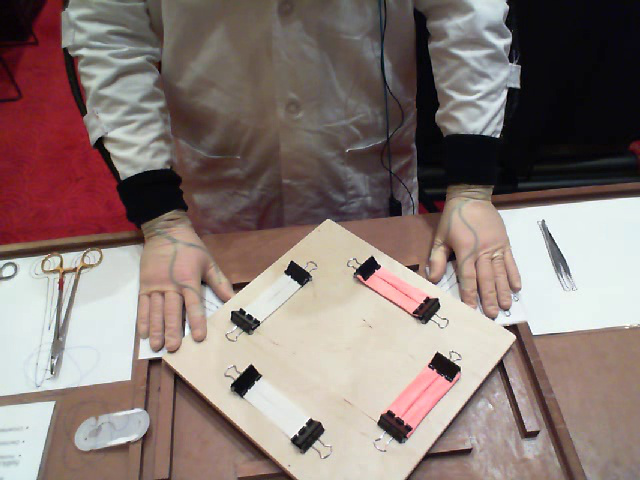

In [205]:
image = Image.open('HW1_dataset/images/'+ 'P016_balloon1_9.jpg')
print(np.asarray(image).shape)
image

In [206]:
def add_bboxes_labels(image_path, bboxes_labels_path):
    
    # Load bounding boxes
    with open(bboxes_labels_path) as f:
        lines = f.readlines()
    bboxes_labels = np.array(list(map(lambda x: [float(num) for num in x],[line.split(' ') for line in lines])))
    bounding_boxes = bboxes_labels[:, 1:]
    labels = bboxes_labels[:, 0]
    
    # Load the image and convert it to RGB
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Convert the normalized bounding boxes to pixel coordinates
    height, width, _ = image.shape
    for i, box in enumerate(bounding_boxes):
        xcenter, ycenter, w, h = box
        xmin = int((xcenter - w / 2) * width)
        ymin = int((ycenter - h / 2) * height)
        xmax = int((xcenter + w / 2) * width)
        ymax = int((ycenter + h / 2) * height)
        
        # Draw the bounding box on the image
        cv2.rectangle(image, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)
        
        # Add the label for the bounding box
        label = classes_names[int(labels[i])]
        cv2.putText(image, label, (xmin, ymin - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    return image

In [207]:
def show_images(dir_path, images):
            
    # Load the images
    images_list = []
    for i in range(9):
        img = add_bboxes_labels(dir_path + 'images/' + images[i], dir_path + 'bboxes_labels/' + images[i][:-3] + 'txt')
        images_list.append(img)

    # Create a figure with a 3x3 grid of subplots
    fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(20, 20))

    # Loop through the subplots and add the images and indices
    for i, ax in enumerate(axes.flat):
        ax.imshow(images_list[i])
        ax.set_title(str(i))
        ax.axis('off')

    # Show the plot
    plt.show(block=True)
    return images_list

In [208]:
images_path = 'HW1_dataset/'

In [209]:
random.seed(0)
sampled_images = random.sample(os.listdir(images_path + 'images/'), 9)

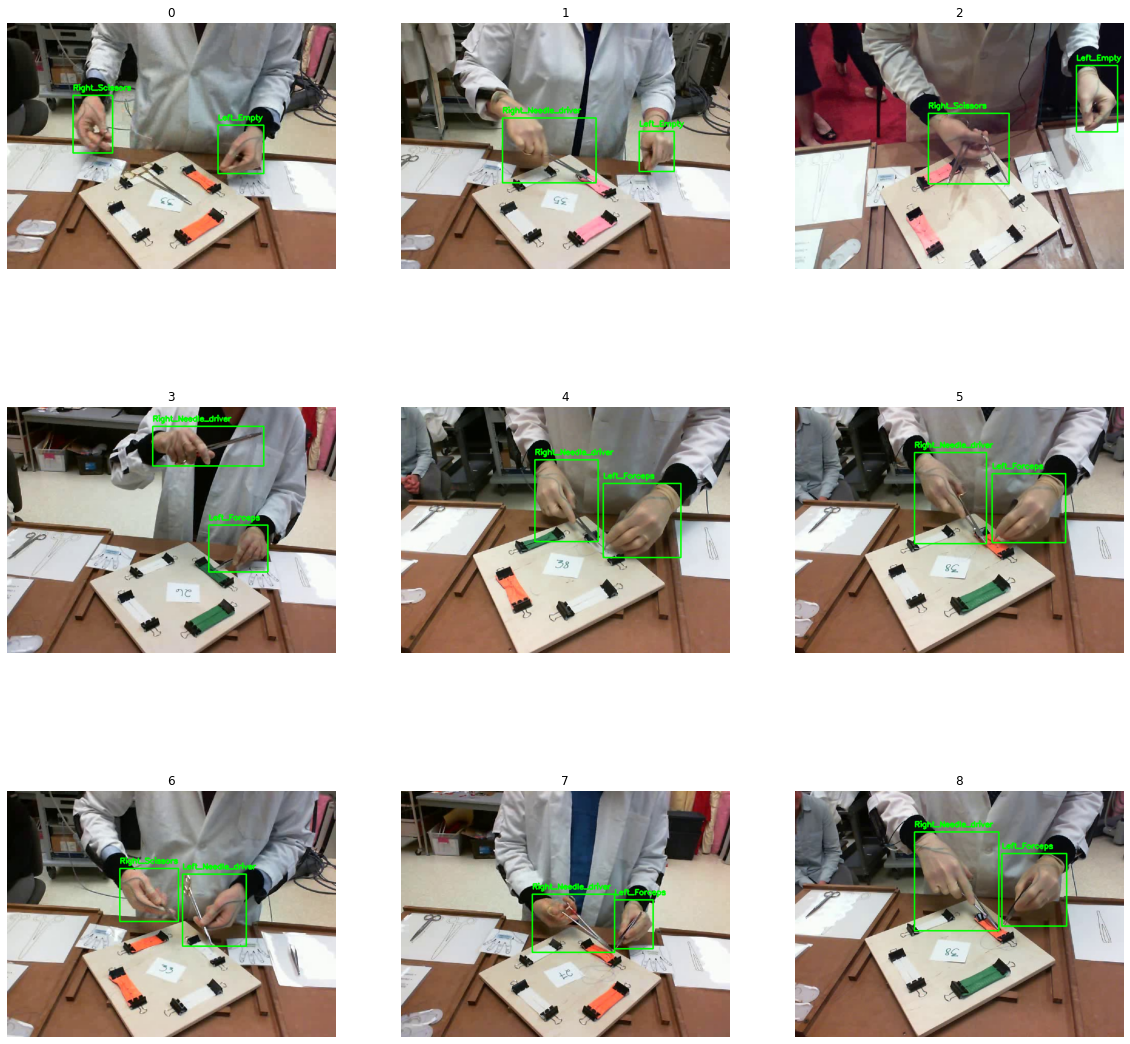

In [210]:
images_list = show_images(images_path, sampled_images)

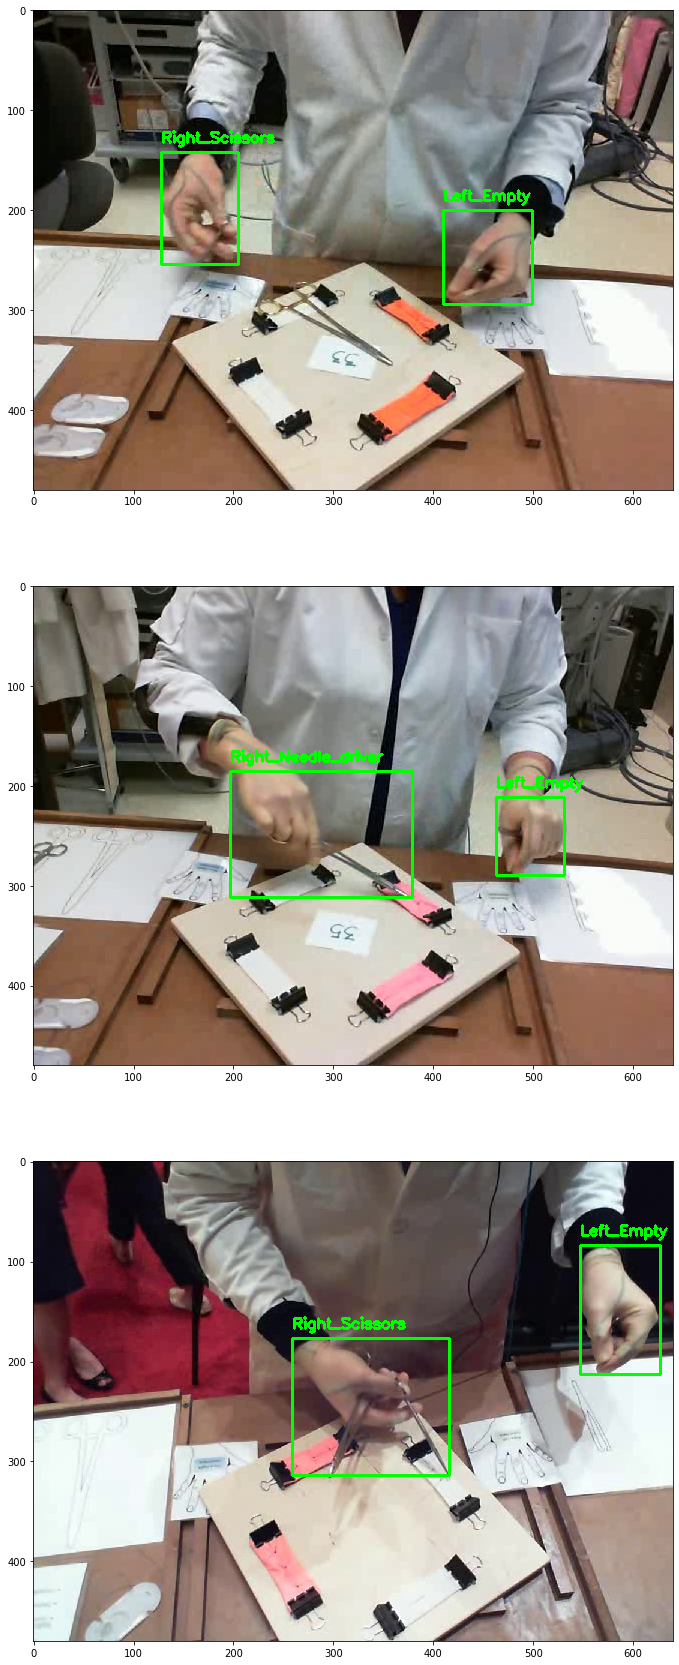

In [211]:
"""
    We can see that images 0, 1, and 2 were labeled incorrectly. 
    Instead of labeling the left hand with "Forceps," it was labeled as "Left Empty." 
    Let's look again at these images.
    
"""
fig, ax = plt.subplots(nrows=3, figsize=(30, 30))
ax[0].imshow(images_list[0])
ax[1].imshow(images_list[1])
ax[2].imshow(images_list[2])
plt.show()

## Split Data to Train, Validation & Test sets

In [212]:
def arrange_data_in_yolov7_format(images_path, src_dir):
    """"
        Arranges data in yolo-v7 format
    
    """""

    dataset_types = ['train', 'valid', 'test']

    # Iterate through each dataset type
    for dataset_type in dataset_types:

        # Set the destination directory for the current dataset type
        dst_dir = "./yolov7/arranged_dataset/" + dataset_type + '/'

        # Create the destination directory if it does not already exist
        if not os.path.exists(dst_dir):
            os.makedirs(dst_dir + 'images/')
            os.makedirs(dst_dir + 'labels/')

        # Open the file containing the list of images for the current dataset type
        with open(src_dir + dataset_type + '.txt', 'r') as f:
            lines = f.readlines()

        # Iterate through each image in the list
        for line in tqdm(lines, desc=dataset_type):

            # Remove the newline character from the image name
            line = line.split('\n')[0]

            # Copy the image and its label to the destination directory
            shutil.copy(src_dir + 'images/' + line, dst_dir + 'images/')
            shutil.copy(src_dir + 'bboxes_labels/' + line.split('.')[0] + '.txt', dst_dir + 'labels/')

In [213]:
images_path = 'HW1_dataset/images/'
src_dir = "./HW1_dataset/"
arrange_data_in_yolov7_format(images_path, src_dir)

test: 100%|██████████████████████████████████████████████████████████████████████████| 199/199 [00:02<00:00, 95.53it/s]


## Data Analysis

In [228]:
def get_data_distribution(data_path):
    dataset_types = ['train', 'valid', 'test']
    data_distribution = {}
    
    for dataset_type in dataset_types:
        
        labels = []
        dir_path = data_path + dataset_type + '/labels/'
        
        for file in os.listdir(dir_path):
            
            # Load Labels
            with open(dir_path + file) as f:
                lines = f.readlines()
            bboxes_labels = np.array(list(map(lambda x: [float(num) for num in x],[line.split(' ') for line in lines])))
            labels.extend(bboxes_labels[:, 0].tolist())
        
        data_distribution[dataset_type] = Counter(labels)
    
    return data_distribution

In [218]:
def plot_distribution(data_path):
    # Data for the pie charts
    data_distribution = get_data_distribution(data_path)
    train = {i: data_distribution['train'][i] if i in data_distribution['train'].keys() else 0 for i in range(8)}
    valid = {i: data_distribution['valid'][i] if i in data_distribution['valid'].keys() else 0 for i in range(8)}
    test = {i: data_distribution['test'][i] if i in data_distribution['test'].keys() else 0 for i in range(8)}

    # Create a figure with 3 subplots
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

    # Plot the first pie chart
    ax1.pie(train.values(), autopct='%1.1f%%')
    ax1.set_title('Train')

    # Plot the second pie chart
    ax2.pie(valid.values(), autopct='%1.1f%%')
    ax2.set_title('Valid')

    # Plot the third pie chart
    ax3.pie(test.values(), autopct='%1.1f%%')
    ax3.set_title('Test')

    # Add a shared legend
    fig.legend(labels=classes_names)

    # Show the plot
    plt.show()

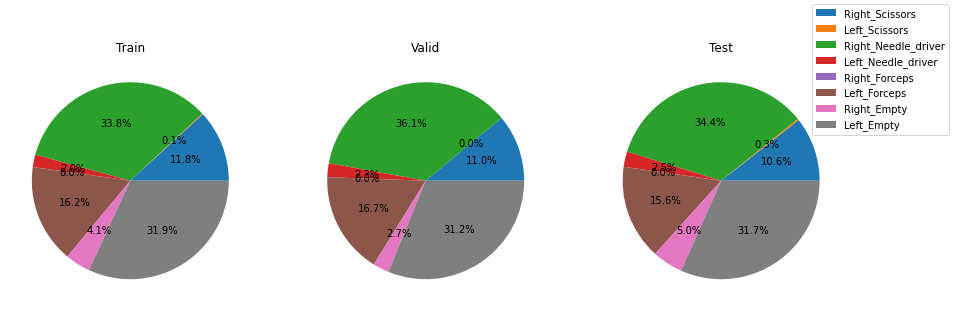

In [219]:
plot_distribution('./yolov7/arranged_dataset/')

<font size="3.5">In this dataset, we can observe that certain classes are more prevalent than others. Specifically, it appears that tools such as scissors and needles are more commonly used in the right hand, while forceps are more commonly used in the left hand. To address this imbalance of classes, we will employ left-right augmentation. Additionally, we can see that the "Left Empty" class has twice as much data as the "Left Scissors" class. <u> In the next step</u>, we will examine the impact of this ratio after <b>correcting</b> the incorrect labels from <b>"Left_Empty"</b> to <b>"Left_Forceps" </b> .</font>

In [220]:
# correct incorrect labels from "Left_Empty" to "Left_Forceps":

corrections = {'P016_balloon1': [(675, 1650), (2127, 3085), (3339, 4451)],
               'P016_tissue1': [(493, 594), (939, 1438), (1703, 3191), (3723, 4081), (4236, 5459), (5838, 6752)],
               'P017_balloon1': [(1767, 2123)],
               'P022_balloon1': [(1307, 3413), (4487, 5477)],
               'P025_balloon1': [(1154, 2375), (3029, 3580), (3724, 3820), (4208, 5042)],
               'P027_balloon1' : [(729, 875)],
               'P027_tissue1': [(1375, 1790), (2197, 3691)],
               'P030_balloon1': [(774, 1720)],
               'P033_balloon1': [(5164, 6392)],
               'P033_tissue1': [(6226, 6802)],
               'P035_balloon1': [(493, 1577), (1715, 2810), (2949, 3604)],
               'P036_balloon1': [(528, 1742), (2060, 3407), (3770, 5416)],
               'P038_balloon1': [(579, 1652), (1937, 2959), (3178, 3964)],
               'P038_tissue1': [(519, 1928), (3880, 4135), (4507, 5559)],
               'P040_balloon1': [(195, 252), (471, 1205)]}

In [222]:
def correct_from_Left_Empty_to_Left_Forceps(data_path):
    
    files = os.listdir(data_path + 'bboxes_labels')
    for file in files:
        splited_name = file.split('_')
        video_name = splited_name[0] + '_' + splited_name[1]
        
        if video_name in corrections.keys():        
            if any([True if int(splited_name[2].split('.')[0]) in range(r[0], r[1]) else False 
                    for r in corrections[video_name]]):

                # Open the file in read mode
                with open(data_path + 'bboxes_labels/' + file, 'r') as f:
                    # Read the contents of the file
                    contents = f.read()

                # Replace the character '7 ' with '5 '
                contents = contents.replace('7 ', '5 ')

                # Open the file in write mode
                with open(data_path + 'bboxes_labels/' + file, 'w') as f:
                    # Write the modified contents to the file
                    f.write(contents)

In [223]:
correct_from_Left_Empty_to_Left_Forceps('HW1_dataset/')

In [224]:
images_path = 'HW1_dataset/images/'
src_dir = "./HW1_dataset/"
arrange_data_in_yolov7_format(images_path, src_dir)

test: 100%|█████████████████████████████████████████████████████████████████████████| 199/199 [00:00<00:00, 382.18it/s]


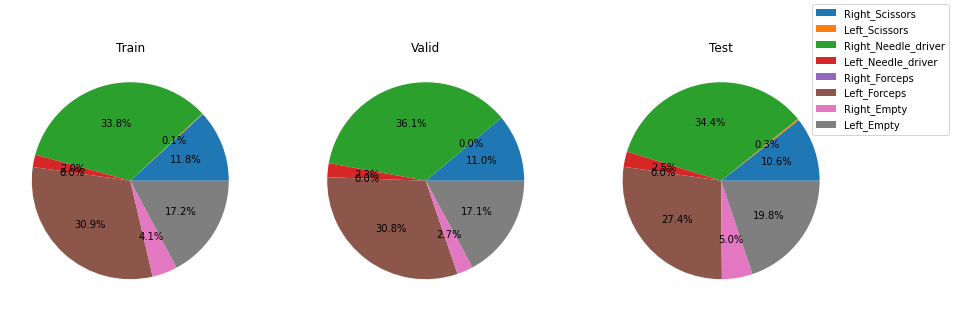

In [229]:
plot_distribution('./yolov7/arranged_dataset/')